# Ce TP est réalisé par le quadrinome :
             Mekdoud Rachid
             Mokhbat Selma
             Kerdjoudj Mohamed
             Hezouat Abdeldjalil

# TP 1 Mesures de performance
Dans ce TP, nous aimerions avoir un premier aperçu sur les algorithmes d'apprentissage automatique. Plus précisément, nous aimerions évaluer leurs performances en utilisant les métriques suivantes:
- Matrice de conusion
- Rappel
- Précision
- Taux de FP
- Spécificité
- Courbe ROC

Les mesures devront être calculées sur la tâche de classification de nombres manuscrits.

Le travail consiste à implementer ces métriques et à les comparer avec les métriques des librairies disponibles.

Les algorithmes : K plus Proches Voisins devront être implementés.

# Importation des librairies necessaires au travail

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import random
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

In [7]:
# Pour RNC
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD

# Lecture des fichiers de données à classifier
Pour ce TP, nous allons lire les données à partir d'un fichier csv.

In [8]:
# données
X = np.genfromtxt('data.csv', delimiter=',', dtype=int)
print(X.shape)
df = pd.read_csv("data.csv",nrows=5000)

(5000, 400)


In [9]:
# étiquettes
y_true = np.genfromtxt('labels.csv', delimiter=',', dtype=int)
y_true.shape

(5000,)

Afficher aléatoirement quelques données de notre base

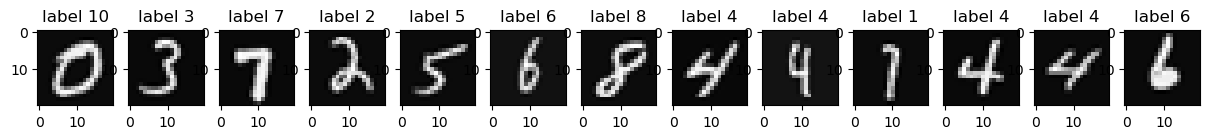

In [6]:
plt.figure(figsize=(15,8))
for i in range(13): #note: each 500 lines, there is a new value
    c = random.randint(X.shape[0]) #pick a random line from the dataset 
    a = X[c,:].reshape((20, 20)) #shape of one number in the image 
    a=np.transpose(a) # la transposé (rendre les ligne des colonne et vice versa)
    plt.subplot(1,13,i+1)
    plt.title('label '+ str(y_true[c]))
    plt.imshow(a,cmap='gray')

Notons que l'étiquette 10 concerne le chiffre 0. L'étiquette a été utilisée ainsi afin de faciliter les calculs conséquents.

# Implémentation des métriques demandées
Ici il faut écrire les fonctions, puis les appeler dans la suite du code

- Matrice de confusion :

In [45]:
def confusion_matrix(y_true, y_pred, normalize=False):
    """ By definition a confusion matrix C
    is such that C_ij
    is equal to the number of observations known to be in group i 
    and predicted to be in group j
    """
    unique = np.unique(np.concatenate((y_true, y_pred)))
    num_of_classes = len(unique)
    matrix = np.zeros((num_of_classes, num_of_classes))
    
    # Generate Confusion Matrix
    for true, pred in zip(y_true, y_pred):
        matrix[true-1][pred-1] += 1
    
    # Matrix Normalization
    if normalize:
        sigma = np.sum(matrix)
        matrix = matrix / sigma
        
    return matrix

In [8]:
y_pred = np.genfromtxt('labels1.csv', delimiter=',', dtype=int)
conf_matrix = confusion_matrix(y_true, y_pred) 
conf_matrix

array([[500,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 500,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0, 500,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0, 500,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0, 500,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0, 500,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0, 500,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 500,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0, 500,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0, 500]], dtype=int64)

- Accuracy = (TP + TN)/(TP + TN + FP + FN)

In [15]:
def accuracy(conf_matrix: np.ndarray) :
    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    return accuracy

- Recall (True Positive Rate) = TP/(TP + FN)

In [17]:
def recall_score(confusion_matrix):
    num_classes = confusion_matrix.shape[0] # nombre de classes
    recalls = []  # liste des recall pour chaque classe
    for i in range(num_classes): # pour chaque classe
        TP = confusion_matrix[i][i] # vrai positif (diagonale)
        FN = sum(confusion_matrix[i, :]) - TP # faux négatif (somme des lignes - vrai positif)
        recall = TP / (TP + FN) # la loi
        recalls.append(recall) # ajouter le recall de la classe i à la liste
    return recalls
 

- Précision = TP/(TP + FP)

In [18]:
def precision_score(confusion_matrix):
    num_classes = confusion_matrix.shape[0] # nombre de classes
    precisions = [] # liste des precisions pour chaque classe
    for i in range(num_classes):  
        TP = confusion_matrix[i][i]  # vrai positif (diagonale)   
        FP = sum(confusion_matrix[:, i]) - TP # faux positif (somme des colonne - vrai positif) 
        precision = TP / (TP + FP)
        precisions.append(precision) # ajouter le recall de la classe i à la liste
    return precisions


- Taux de FP (False Positive Rate) = FP / (FP + TN)

In [19]:
def false_positive_rate(conf_matrix):
    # Calculer le nombre de classes
    num_classes = conf_matrix.shape[0]
    # Initialiser la liste pour stocker les FPR de chaque classe
    fpr_list = []
    # Calculer le FPR pour chaque classe
    for i in range(num_classes):
        # Initialiser les variables pour stocker le nombre de faux positifs (FP) et vrais négatifs (TN)
        false_positives = 0
        true_negatives = 0
        # Calculer le nombre de faux positifs et vrais négatifs pour la classe i
        for j in range(num_classes):
            if i != j:
                false_positives += conf_matrix[j, i]
                true_negatives += np.sum(conf_matrix) - np.sum(conf_matrix[j, :]) - np.sum(conf_matrix[:, i]) + conf_matrix[j, i]
        # Calculer le FPR pour la classe i
        fpr = false_positives / (false_positives + true_negatives)
        # Ajouter le FPR à la liste
        fpr_list.append(fpr)
    # Calculer le FPR moyen
    fpr_mean = np.mean(fpr_list)
    # Retourner la liste des FPR pour chaque classe et le FPR moyen
    return fpr_list, fpr_mean


- Spécificité (True Negative Rate) = TN / (TN + FP)

In [20]:
def specificite(confusion_matrix):
    # taux de spécificité
    num_classes = confusion_matrix.shape[0] # nombre de classes
    specificities = [] # liste des recall pour chaque classe
    for i in range(num_classes):
        # vrai négatif (somme totale - somme de la ligne i - somme de la colonne i + diagonale) 
        TN = sum(sum(confusion_matrix)) - sum(confusion_matrix[i, :]) - sum(confusion_matrix[:, i]) + confusion_matrix[i][i] 
        FP = sum(confusion_matrix[:, i]) - confusion_matrix[i][i] # faux positif (somme des lignes - vrai positif)
        specificity = TN / (TN + FP)
        specificities.append(specificity) # inserer la classe i dans la liste des taux de fp
    mean_specificity = sum(specificities) / num_classes
    return specificities, mean_specificity



- Courbe ROC

In [14]:
from sklearn.metrics import roc_curve, auc

def roc(Ytt, y_score):
    n_classes=10
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(Ytt[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    for i in range(n_classes):
        plt.figure()
        plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic example')
        plt.legend(loc="lower right")
        plt.show()

# Classification

Définir d'abord la base d'entrainement Xt, Yt et la base de test Xtt, Ytt

In [15]:
scaler = StandardScaler()
scaler.fit(X)
scaled_features = scaler.transform(X)
Xt, Xtt, Yt, Ytt = train_test_split(scaled_features, y_true , test_size = 0.30)

In [16]:
#les données pour la courbe roc
from sklearn.preprocessing import label_binarize

y_true = label_binarize(y_true, classes=[1,2,3,4,5,6,7,8,9,10])
Xtr, Xttr, Ytr, Yttr = train_test_split(X, y_true, test_size=0.333)

# Méthode 0: K- Plus Proches Voisins

Ici il faudra implémenter la méthode, puis la tester et vérifier les métriques en variant le nombre K

In [17]:
from sklearn.multiclass import OneVsRestClassifier

def KNN(Xt, Xtt, Yt, k):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(Xt, Yt)
    pred = knn.predict(Xtt)
    return pred 

pred = KNN(Xt, Xtt, Yt, k=4)

conf_matrix = np.array(confusion_matrix(Ytt, pred))
print("Matrice de confusion:\n", conf_matrix)

Matrice de confusion:
 [[157   0   1   1   0   0   1   0   0   0]
 [  7 119   7   2   0   5   1   1   0   3]
 [  4   3 136   1   4   0   2   6   2   0]
 [  2   0   2 126   2   2   3   0   7   0]
 [  2   0  13   1 117   1   2   1   3   1]
 [  2   2   0   1   3 153   0   0   1   4]
 [  4   1   2   4   1   0 122   0  15   0]
 [  1   2   3   0  15   0   0 104   4   0]
 [  2   3   3   4   1   1  11   5 126   0]
 [  0   2   0   1   0   4   0   1   0 144]]


In [18]:
#Accuracy
acc=accuracy(conf_matrix)
acc

0.8693333333333333

In [19]:
#Rappel True positive 
rappel=recall_score(conf_matrix)
#print(rappel)
mean_recall = np.mean(rappel)
print(mean_recall)

0.8669227355315066


In [20]:
#Precision
p=precision_score(conf_matrix)
mean_pr = np.mean(p)
print(mean_pr)

0.870212294762754


In [21]:
#faux positive
fpr_list, fpr_mean = false_positive_rate(conf_matrix)
print(fpr_mean)

0.0018118693165768596


In [22]:
#true negative
tp_list,tp_mean=specificite(conf_matrix)
print(tp_mean)

0.9854697201148379


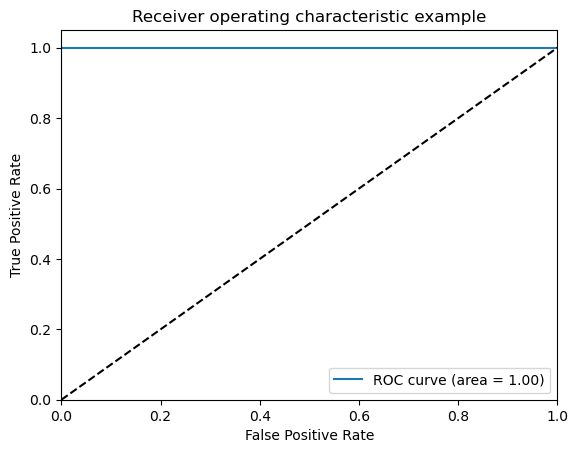

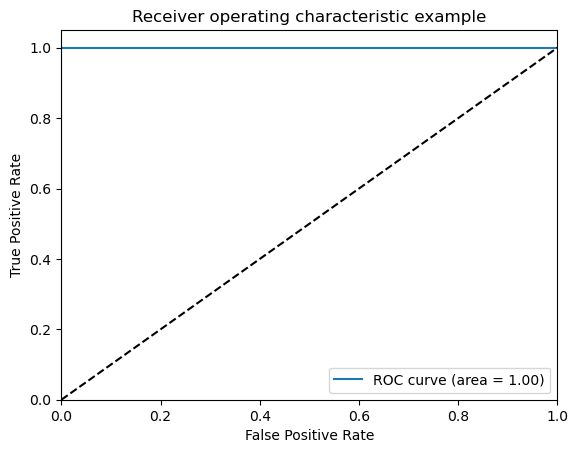

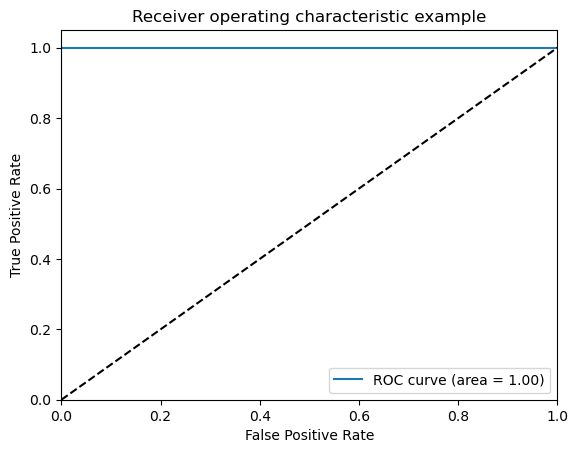

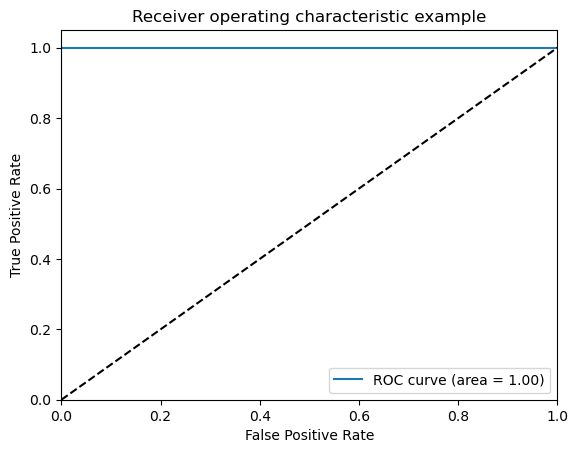

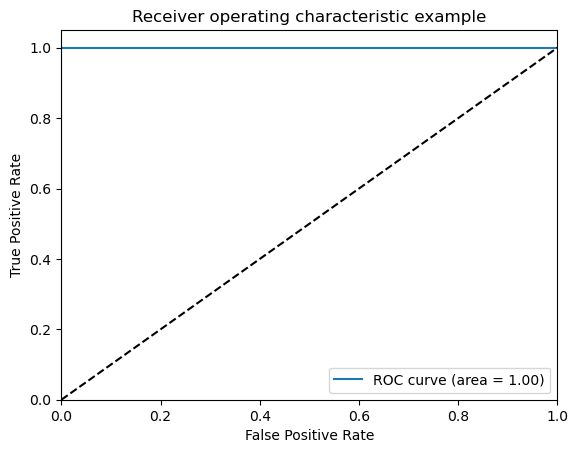

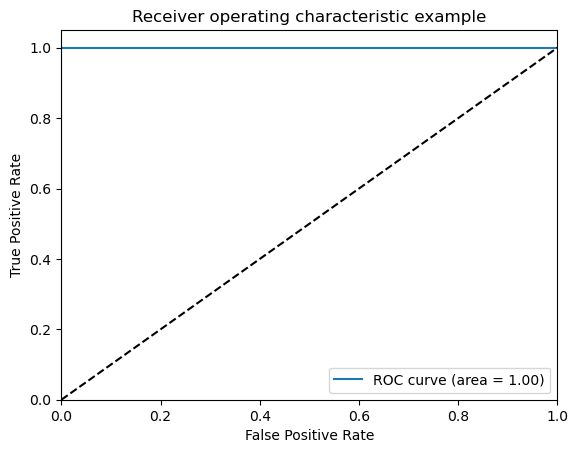

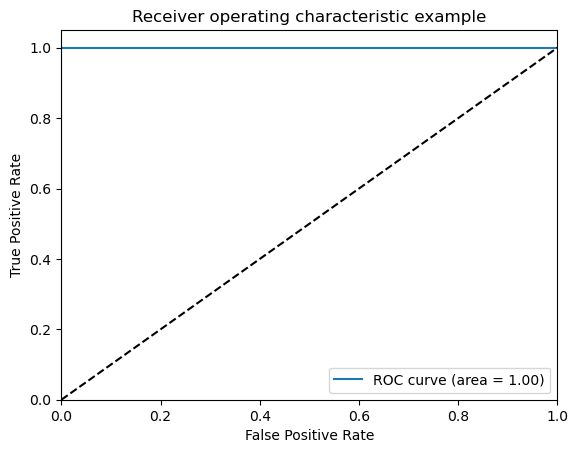

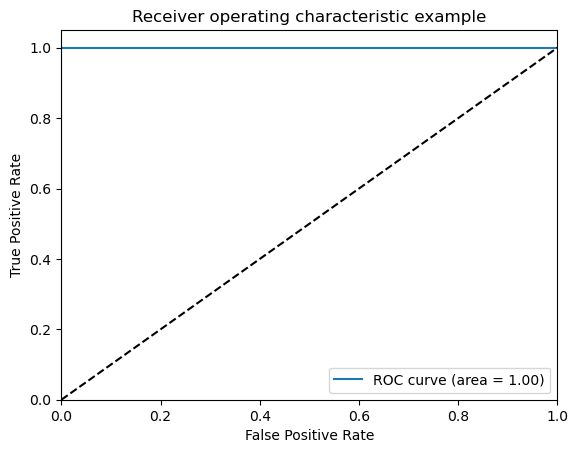

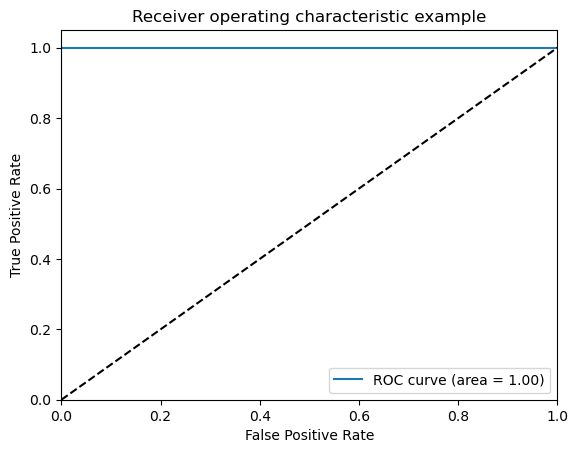

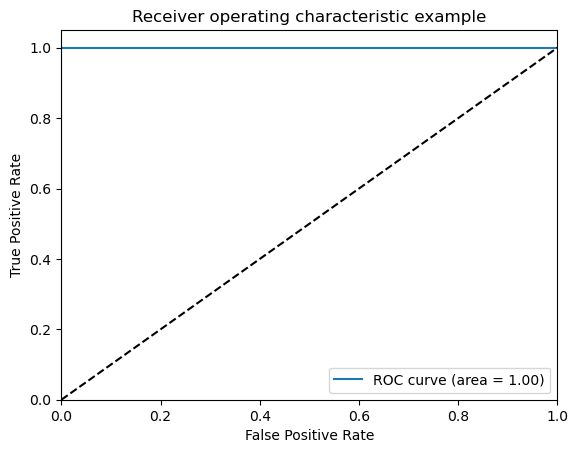

In [23]:
#courbe roc
knn_clf = OneVsRestClassifier(KNeighborsClassifier(weights='distance', n_neighbors=4))
knn_clf.fit(Xtr, Ytr)
y_score = knn_clf.predict_proba(Xtr)
roc(Ytr, y_score)

# Méthode 1: MVS
Machine à Vecteurs de Support

In [24]:
#Créer le modèle
model= svm.SVC(kernel='linear') 
# entrainement 
model.fit(Xt, Yt)
# Prediction
y_pred = model.predict(Xtt)

6
Matrice de confusion:
 [[157   0   0   2   0   0   1   0   0   0]
 [  1 134   0   2   1   3   1   3   0   0]
 [  3   3 137   1   6   0   1   5   1   1]
 [  0   0   3 132   0   1   0   1   6   1]
 [  2   1   7   1 126   1   0   1   1   1]
 [  0   3   0   2   2 158   0   0   0   1]
 [  1   0   2   3   0   0 131   1  11   0]
 [  1   3   2   1   2   3   0 113   3   1]
 [  0   0   3   5   0   0   2   2 144   0]
 [  0   3   0   0   0   2   0   1   0 146]]


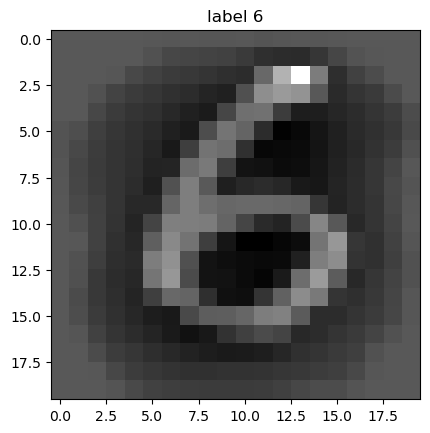

In [25]:
# tester une image
c= 3
print (y_pred[c])
a = Xtt[c,:].reshape((20, 20))
a=np.transpose(a)
plt.title('label '+ str(Ytt[c]))
plt.imshow(a,cmap='gray')

conf_matrix = np.array(confusion_matrix(Ytt, y_pred))
print("Matrice de confusion:\n", conf_matrix)

In [26]:
#Accuracy
acc=accuracy(conf_matrix)
acc

0.9186666666666666

In [27]:
#Rappel True positive 
rappel=recall_score(conf_matrix)
#print(rappel)
mean_recall = np.mean(rappel)
print(mean_recall)

0.9173334317475288


In [28]:
#Precision
p=precision_score(conf_matrix)
mean_pr = np.mean(p)
print(mean_pr)

0.9186136797299429


In [29]:
#faux positive
fpr_list, fpr_mean = false_positive_rate(conf_matrix)
print(fpr_mean)

0.0011277944478728051


In [30]:
#true negative
tp_list,tp_mean=specificite(conf_matrix)
print(tp_mean)

0.9909650049547117


In [31]:
#courbe roc
from sklearn.model_selection import cross_val_predict
from sklearn.multiclass import OneVsRestClassifier
model = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True))
model.fit(Xtr, Ytr)
yt_pred = cross_val_predict(model, Xtr, Ytr, cv=3, method='predict_proba')
roc(Ytr, yt_pred)

KeyboardInterrupt: 

# Méthode 2: Arbres de décision


In [32]:
# Créer le modèle
model = DecisionTreeClassifier()
# Entrainer le modèle
model = model.fit(Xt, Yt)
# Prediction
y_pred = model.predict(Xtt)

7
Matrice de confusion:
 [[144.   5.   5.   2.   0.   1.   3.   2.   0.   0.]
 [  3.  82.   9.   4.   3.   8.   4.  12.   2.   2.]
 [  1.   6. 102.   0.  15.   4.   6.   3.   5.   0.]
 [  2.   7.   0. 110.   1.   2.   2.   0.   8.   1.]
 [  2.   8.  16.   6.  97.   6.   4.   8.   6.   5.]
 [  4.   9.   1.   3.  16. 118.   1.   7.   1.   2.]
 [  0.  10.   1.   1.   1.   0. 126.   4.   7.   0.]
 [  4.   8.   9.   1.  12.   3.   3. 121.   7.   2.]
 [  2.   4.   7.   4.   3.   2.   3.   7. 116.   0.]
 [  2.   2.   3.   0.   3.   3.   3.   2.   1. 127.]]


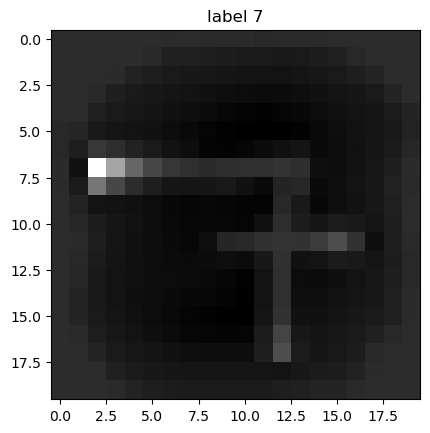

In [ ]:
# tester une image
c= 3
print (y_pred[c])
a = Xtt[c,:].reshape((20, 20))
a=np.transpose(a)
plt.title('label '+ str(Ytt[c]))
plt.imshow(a,cmap='gray')

conf_matrix = np.array(confusion_matrix(Ytt, y_pred))
print("Matrice de confusion:\n", conf_matrix)

In [33]:
#Accuracy
acc=accuracy(conf_matrix)
acc

0.9186666666666666

In [34]:
#Rappel True positive 
rappel=recall_score(conf_matrix)
#print(rappel)
mean_recall = np.mean(rappel)
print(mean_recall)

0.9173334317475288


In [35]:
#Precision
p=precision_score(conf_matrix)
mean_pr = np.mean(p)
print(mean_pr)

0.9186136797299429


In [36]:
#faux positive
fpr_list, fpr_mean = false_positive_rate(conf_matrix)
print(fpr_mean)

0.0011277944478728051


In [37]:
#true negative
tp_list,tp_mean=specificite(conf_matrix)
print(tp_mean)

0.9909650049547117


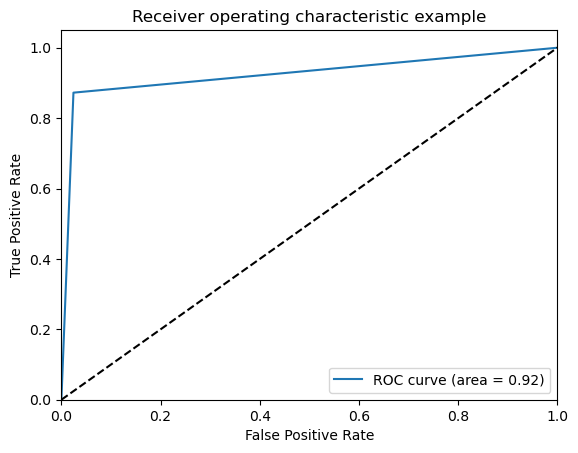

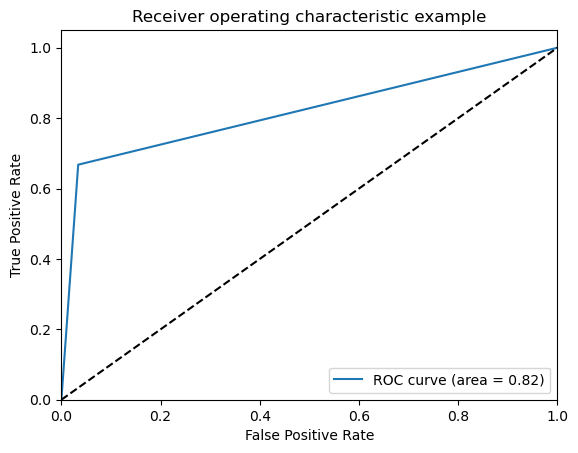

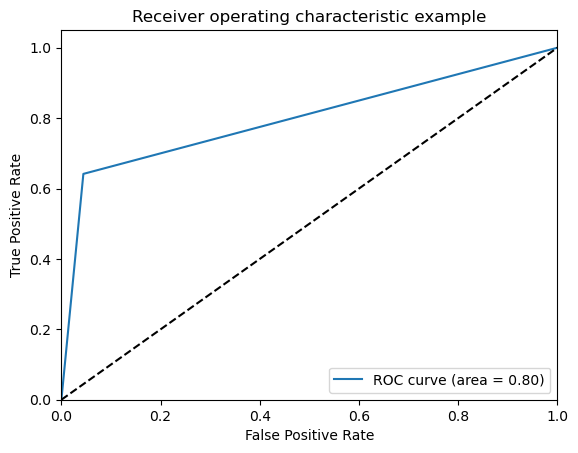

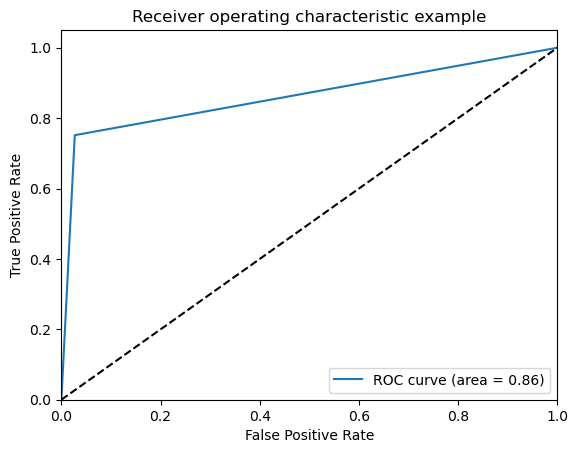

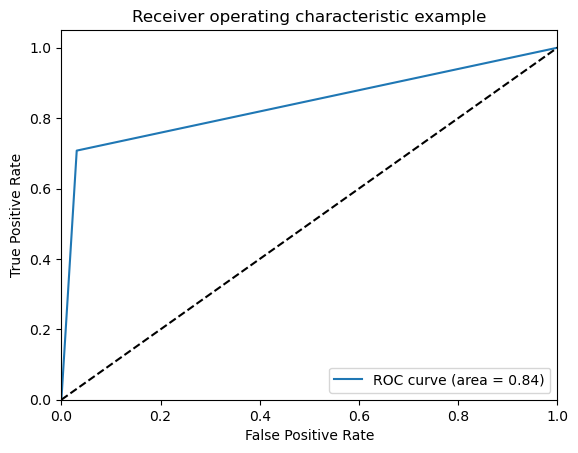

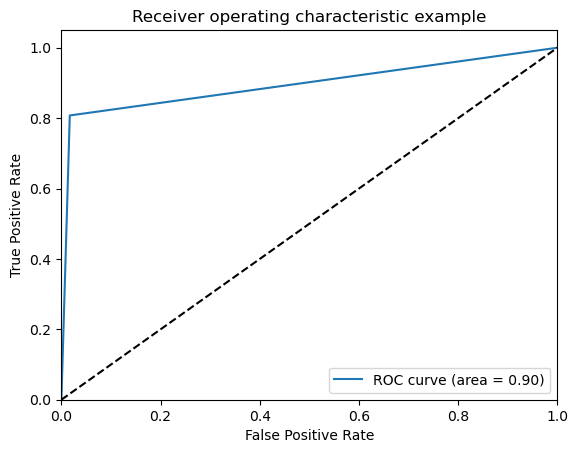

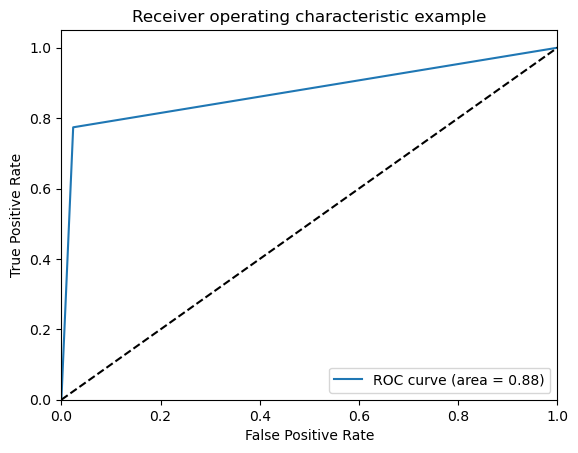

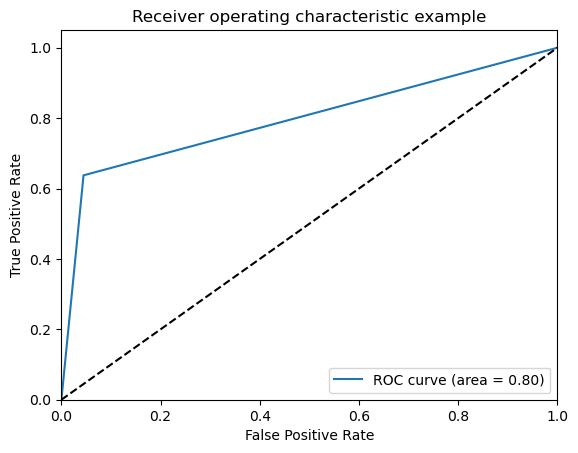

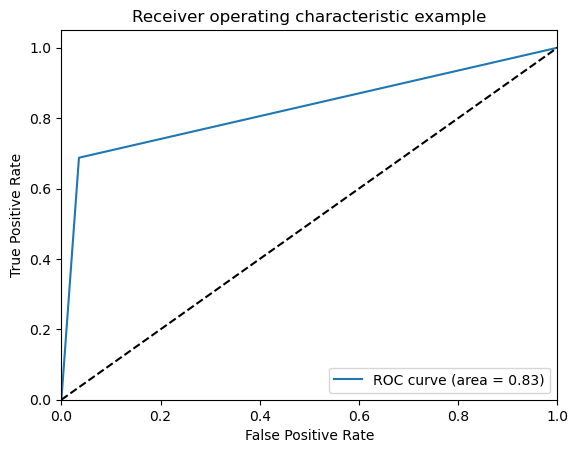

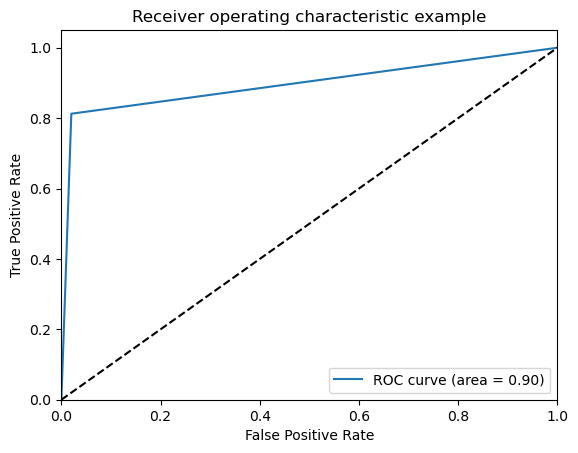

In [38]:
#courbe roc
model = OneVsRestClassifier(model)
model.fit(Xtr, Ytr)
yt_pred = cross_val_predict(model, Xtr, Ytr, cv=3, method='predict_proba')
roc(Ytr, yt_pred)

6


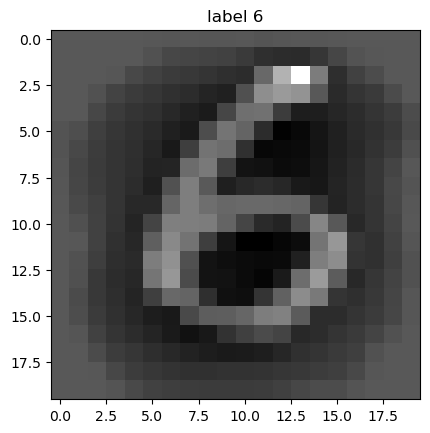

In [39]:
# tester une image
c= 3
print (y_pred[c])
a = Xtt[c,:].reshape((20, 20))
a=np.transpose(a)
plt.title('label '+ str(Ytt[c]))
plt.imshow(a,cmap='gray')

# Méthode 3: RN 
Réseaux de neurones Perceptron

In [47]:
model = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(25),max_iter=100000)
Xt, Xtt, Yt, Ytt = train_test_split(X, y_true, random_state=0, test_size=0.7)
model.fit(Xt, Yt)
y_pred = model.predict(Xtt)

In [48]:
# Choisir un image de test 
c=0

In [49]:
model.predict([Xtt[c,:]])

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [50]:
# pour ROC, il faudra les probabilités:
model.predict_proba([Xtt[c,:]])


array([[0.10969741, 0.10855674, 0.10487589, 0.11630493, 0.10919086,
        0.11333016, 0.11075995, 0.11078939, 0.10969089, 0.10841933]])

Afficher l'image testée

Matrice de confusion:
 [[0. 0.]
 [0. 0.]]


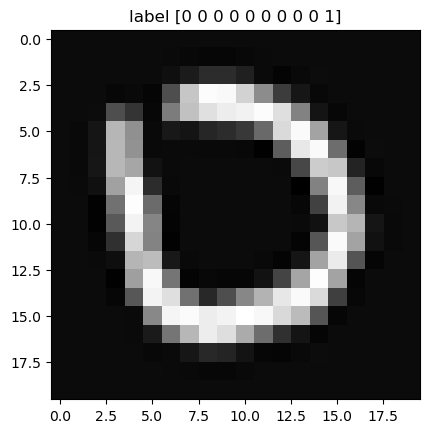

In [51]:
a = Xtt[c,:].reshape((20, 20))
a=np.transpose(a)
plt.title('label '+ str(Ytt[c]))
plt.imshow(a,cmap='gray')
conf_matrix = confusion_matrix(Ytt, y_pred)
print("Matrice de confusion:\n", conf_matrix)

In [ ]:
#Accuracy
acc=accuracy(conf_matrix)
acc

0.19457142857142856

In [ ]:
#Rappel True positive 
rappel=recall_score(conf_matrix)
#print(rappel)
mean_recall = np.mean(rappel)
print(mean_recall)

0.1963225245014884


In [ ]:
#Precision
p=precision_score(conf_matrix)
mean_pr = np.mean(p)
print(mean_pr)

0.735482425689472


In [ ]:
#faux positive
fpr_list, fpr_mean = false_positive_rate(conf_matrix)
print(fpr_mean)

0.0036298119082863118


In [ ]:
#true negative
tp_list,tp_mean=specificite(conf_matrix)
print(tp_mean)

0.9707374018627603


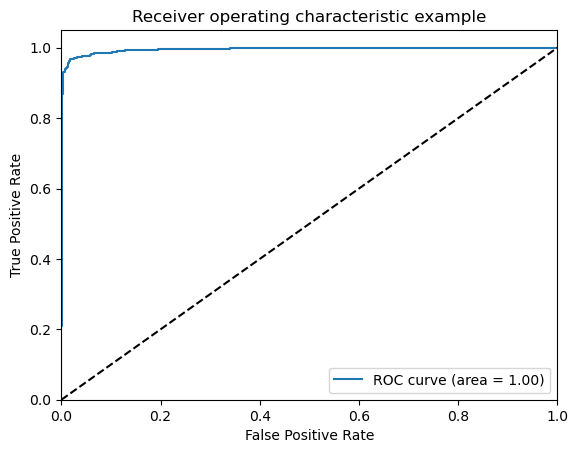

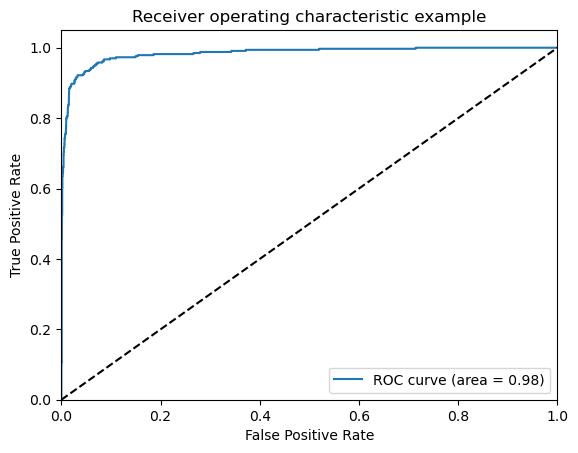

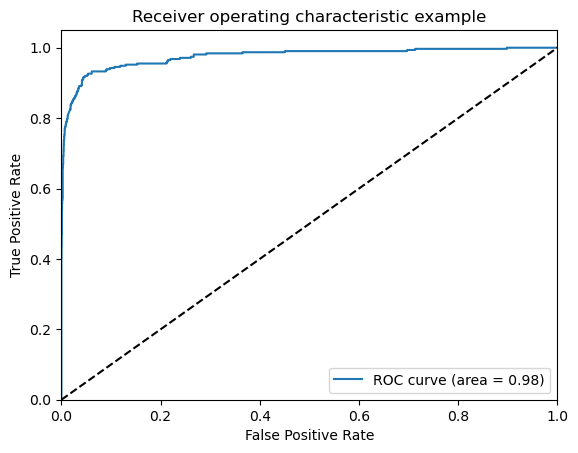

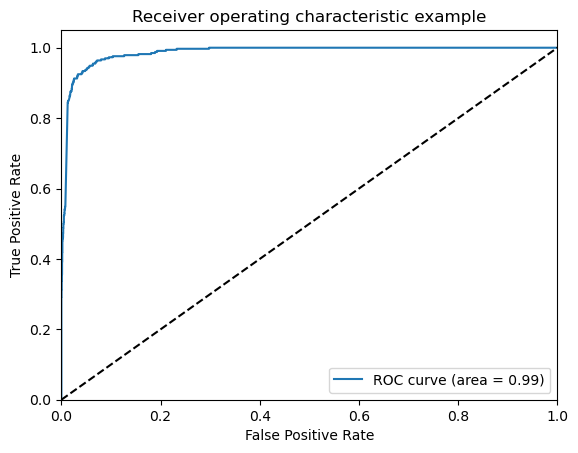

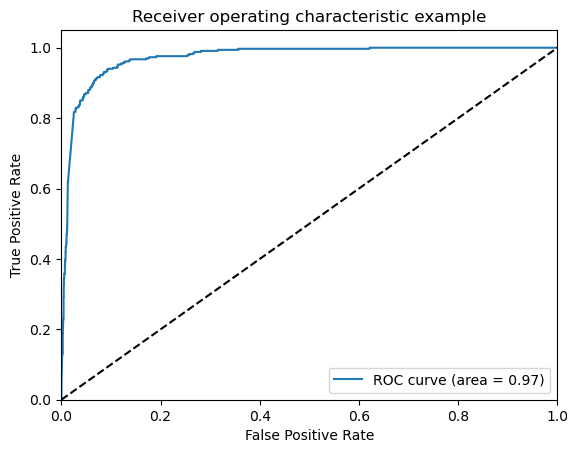

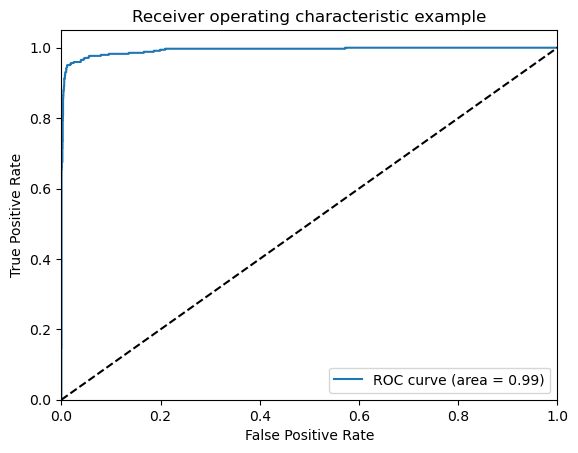

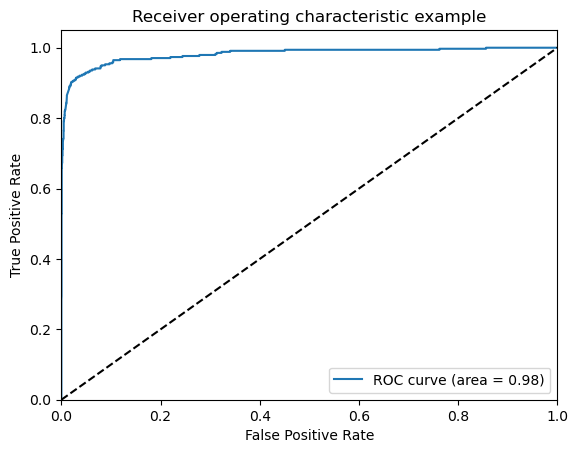

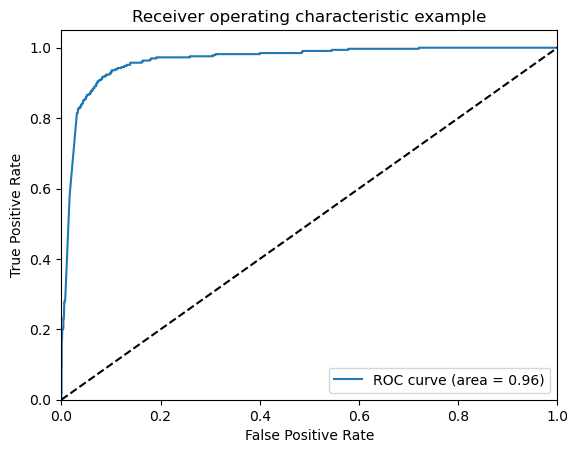

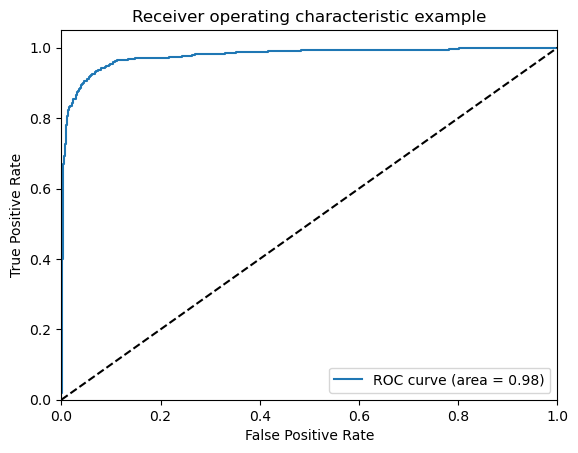

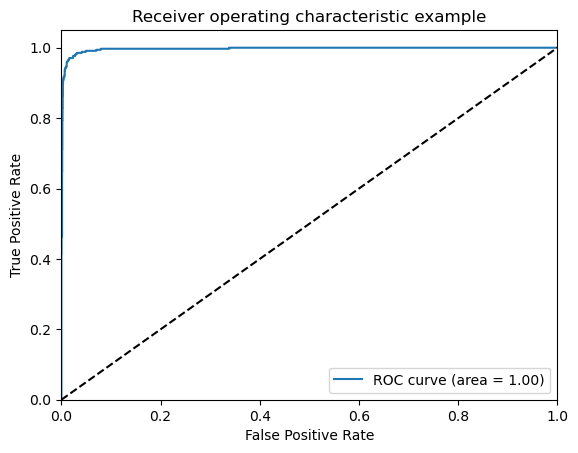

In [ ]:
#courbe roc
model = OneVsRestClassifier(model)
model.fit(Xtr, Ytr)
yt_pred = cross_val_predict(model, Xtr, Ytr, cv=3, method='predict_proba')
roc(Ytr, yt_pred)

# Méthode 4: RNC
Réseaux de Neurones Convolutifs

In [10]:
# reshape dataset to have a single channel
from sklearn.model_selection import train_test_split
Xt, Xtt, Yt, Ytt = train_test_split(X, y_true, random_state=0, test_size=0.7)

Xt_rnc = Xt.reshape((Xt.shape[0], 20, 20, 1))
Xtt_rnc = Xtt.reshape((Xtt.shape[0], 20, 20, 1))

In [11]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from keras.optimizers import SGD
from keras.utils import to_categorical

# Recoder les valeurs cibles en encodage one-hot
Yt_rnc = to_categorical(Yt)
Ytt_rnc = to_categorical(Ytt)

# Convertir les images en type float32 et normaliser les pixels entre 0 et 1
Xt_rncN = Xt_rnc.astype('float32') / 255.0
Xtt_rncN = Xtt_rnc.astype('float32') / 255.0

# Définir le modèle RNC
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(20, 20, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(11, activation='softmax'))

# Compiler le modèle avec l'optimiseur SGD, une fonction de perte de catégorisation croisée et une métrique d'exactitude
opt = SGD(lr=0.01, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Entraîner le modèle sur les données d'entraînement
model.fit(Xt_rncN, Yt_rnc, epochs=10, batch_size=32, verbose=1)

# Evaluer le modèle sur les données de test et afficher l'exactitude
_, acc = model.evaluate(Xtt_rncN, Ytt_rnc, verbose=0)
print('Exactitude du modèle : %.2f%%' % (acc * 100.0))

C:\Users\pc\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/10
47/47 [==============================] - 1s 11ms/step - loss: 1.0913 - accuracy: 0.6560
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.4244 - accuracy: 0.8740
Epoch 3/10
47/47 [==============================] - 0s 10ms/step - loss: 0.3112 - accuracy: 0.9053
Epoch 4/10
47/47 [==============================] - 0s 10ms/step - loss: 0.2208 - accuracy: 0.9320
Epoch 5/10
47/47 [==============================] - 0s 10ms/step - loss: 0.1866 - accuracy: 0.9473
Epoch 6/10
47/47 [==============================] - 0s 10ms/step - loss: 0.1438 - accuracy: 0.9573
Epoch 7/10
47/47 [==============================] - 0s 10ms/step - loss: 0.1216 - accuracy: 0.9687
Epoch 8/10
47/47 [==============================] - 0s 10ms/step - loss: 0.0908 - accuracy: 0.9787
Epoch 9/10
47/47 [==============================] - 0s 10ms/step - loss: 0.0813 - accuracy: 0.9813
Epoch 10/10
47/47 [==============================] - 0s 10ms/step - loss: 0.0603 - accuracy: 0.9887
Exactitud

In [12]:
from sklearn.metrics import confusion_matrix

# Prédire les probabilités pour chaque classe sur l'ensemble de test
Ytt_prob = model.predict(Xtt_rnc)

# Convertir les probabilités en étiquettes prédites
Ytt_pred = np.argmax(Ytt_prob, axis=1)

# Créer la matrice de confusion
cm = confusion_matrix(Ytt, Ytt_pred)

# Afficher la matrice de confusion
print(cm)


110/110 [==============================] - 1s 4ms/step
[[340   3   1   0   2   0   0   5   0   0]
 [  1 341   1   1   0   0   0   4   1   5]
 [  1  10 306   0  22   1   4  11   2   1]
 [  2   8   0 308   0   7   1   3   9   0]
 [  0   2   2   4 325   3   0   8   4   3]
 [  0   3   0   0   5 329   0   1   0   5]
 [  0  10   5   6   0   0 313   3  11   2]
 [  0   9   1   1   5   1   0 330   2   1]
 [  1   2   5   4   4   0  10   2 312  11]
 [  0   3   0   0   3   1   1   0   0 346]]


In [21]:
#Rappel True positive 
rappel=recall_score(cm)
#print(rappel)
mean_recall = np.mean(rappel)
print(mean_recall)

0.9286471487091974


In [22]:
#Precision
p=precision_score(cm)
mean_pr = np.mean(p)
print(mean_pr)

0.9302124810715915


In [24]:
#faux positive
fpr_list, fpr_mean = false_positive_rate(cm)
print(fpr_mean)

0.0009929718567391395


In [26]:
#true negative
tp_list,tp_mean=specificite(cm)
print(tp_mean)

0.992061217873764


In [ ]:
#courbe roc
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Entraîner le modèle RNC et prédire les probabilités
model.fit(X_train, y_train)
y_prob = model.predict_proba(X_test)[:,1]

# Calculer la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculer l'aire sous la courbe (AUC)
roc_auc = auc(fpr, tpr)

# Tracer la courbe ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Courbe ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC pour le modèle RNC')
plt.legend(loc="lower right")
plt.show()


# Analyse des résultats

<img src="analyseresultat.png" alt="Tableau de comparaison">

Le tableau ci dessus représente les différentes mesures de performances pour les 4 méthodes que nous avons implémenter :Les K-plus proches voisins, MVS, Arbres de décisions, RN et RNC.

           .    K-plus proches voisins  : Ce modèle a une précision et un rappel de 0,87, ce qui est relativement élevé. L'accuracy est de 0,874, ce qui signifie que le modèle a correctement classé 87,4 % des échantillons. Le modèle a un faible taux de faux positifs (FP) de 0,0017 et une haute spécificité de 0,98.

    MVS  : Ce modèle a une précision et un rappel de 0,902, ce qui est légèrement supérieur à la méthode 0. L'accuracy est de 0,90, ce qui signifie que le modèle a correctement classé 90 % des échantillons. Le modèle a un faible taux de faux positifs (FP) de 0,0013 et une haute spécificité de 0,98, similaire à la méthode 0.

    Arbre de décision: Ce modèle a une précision de 0,757, qui est inférieure aux méthodes précédentes. Le rappel est également faible, à 0,75. L'accuracy est de 0,75, ce qui signifie que le modèle a correctement classé 75 % des échantillons. Le modèle a un taux de faux positifs (FP) légèrement plus élevé que les deux premières méthodes, à 0,003, et une spécificité de 0,97.

    RN : Ce modèle a une précision de 0,735 et un rappel de 0,739, qui sont inférieurs aux méthodes précédentes. L'accuracy est de 0,736, ce qui signifie que le modèle a correctement classé 73,6 % des échantillons. Le modèle a un taux de faux positifs (FP) légèrement plus élevé que la méthode 2, à 0,003, et une spécificité de 0,97.

    RNC  : Ce modèle a une précision et un rappel élevés, à 0,93 et 0,928 respectivement. L'accuracy est de 0,93, ce qui signifie que le modèle a correctement classé 93 % des échantillons. Le modèle a un très faible taux de faux positifs (FP) de 0,0009 et une haute spécificité de 0,99.

# Conclusion 
En résumé, la méthode 4 (RNC) est le modèle qui a les meilleures performances, avec une haute précision, un rappel élevé, une très faible taux de faux positifs et une haute spécificité. Les méthodes 0 et 1 ont également des performances relativement élevées, tandis que les méthodes 2 et 3 ont des performances plus faibles.